In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from os import listdir
from torch.utils.tensorboard import SummaryWriter

from torchvision import models
from torchsummary import summary

import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math

In [2]:
import gc

gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Conputation is running on {}'.format(device))

This Conputation is running on cpu


Bilder importieren
-

In [3]:
#transforms = transforms.ToTensor()
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
])

batchSize = 128

#Bilder aus dem verzeichnis in einen Tensor schreiben
true_images_list = []
for f in listdir('C:/Users/meldr/PythonProjects/GAN-Bilder/AnimeTMgroß/'):
    # f ist gleich der Dateiname
    img = Image.open("C:/Users/meldr/PythonProjects/GAN-Bilder/AnimeTMgroß/" + f)
    img_tensor = transforms(img) 
    true_images_list.append(img_tensor)
train_data = torch.stack(true_images_list) #Liste mit Image-Tensoren

#DataLoader für echte Bilder
trueloader = torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=True, num_workers=2) #pin_memory=True -> GPU

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__() #Superkonstruktor für das NN
        self.generate = nn.Sequential(
            #nn.ConvTranspose2d(3, 256, 4, stride=2, padding=2), 
            #nn.ReLU(), #Relu-Aktivierungsfunktion
            #nn.BatchNorm2d(256),
            #nn.ConvTranspose2d(3, 1024, 3, stride=1, padding=1), 
            #nn.BatchNorm2d(1024),
            #nn.ReLU(),  # Relu-Aktivierungsfunktion
            nn.ConvTranspose2d(3, 8, 5, stride=3, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(),  # Relu-Aktivierungsfunktion
            nn.ConvTranspose2d(8, 64, 6, stride=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),  # Relu-Aktivierungsfunktion
            nn.ConvTranspose2d(64, 32, 6, stride=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),  # Relu-Aktivierungsfunktion
            nn.ConvTranspose2d(32, 3, 6, stride=2, padding=1),
            nn.Tanh() 
        )
        
    def forward(self,x):
        #print(f'Input Generator:{x.shape}')
        generated = self.generate(x)
        #print(f'Output Generator:{generated.shape}')
        return generated
    


In [5]:
#Summary vom Generator
gen_sum = Generator().to(device)
summary(gen_sum, (3, 1, 1))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 8, 3, 3]             608
|    └─BatchNorm2d: 2-2                  [-1, 8, 3, 3]             16
|    └─ReLU: 2-3                         [-1, 8, 3, 3]             --
|    └─ConvTranspose2d: 2-4              [-1, 64, 10, 10]          18,496
|    └─BatchNorm2d: 2-5                  [-1, 64, 10, 10]          128
|    └─ReLU: 2-6                         [-1, 64, 10, 10]          --
|    └─ConvTranspose2d: 2-7              [-1, 32, 31, 31]          73,760
|    └─BatchNorm2d: 2-8                  [-1, 32, 31, 31]          64
|    └─ReLU: 2-9                         [-1, 32, 31, 31]          --
|    └─ConvTranspose2d: 2-10             [-1, 3, 64, 64]           3,459
|    └─Tanh: 2-11                        [-1, 3, 64, 64]           --
Total params: 96,531
Trainable params: 96,531
Non-trainable params: 0
To

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 8, 3, 3]             608
|    └─BatchNorm2d: 2-2                  [-1, 8, 3, 3]             16
|    └─ReLU: 2-3                         [-1, 8, 3, 3]             --
|    └─ConvTranspose2d: 2-4              [-1, 64, 10, 10]          18,496
|    └─BatchNorm2d: 2-5                  [-1, 64, 10, 10]          128
|    └─ReLU: 2-6                         [-1, 64, 10, 10]          --
|    └─ConvTranspose2d: 2-7              [-1, 32, 31, 31]          73,760
|    └─BatchNorm2d: 2-8                  [-1, 32, 31, 31]          64
|    └─ReLU: 2-9                         [-1, 32, 31, 31]          --
|    └─ConvTranspose2d: 2-10             [-1, 3, 64, 64]           3,459
|    └─Tanh: 2-11                        [-1, 3, 64, 64]           --
Total params: 96,531
Trainable params: 96,531
Non-trainable params: 0
To

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__() #Superkonstruktor für das NN
        
        #batch_size = 4, size = 2500 (50x50 Pixel)
        self.discriminate = nn.Sequential(
            #nn.Conv2d(3, 256, 5, stride=2, padding=1), # 2500=(1+2500-5+2*2)/1
            #nn.ReLU(), #Relu-Aktivierungsfunktion
            #nn.BatchNorm2d(256),
            #nn.Conv2d(3, 128, 5, stride=2, padding=1), # 625=(1+2500-5+2*2)/2
            #nn.BatchNorm2d(128),
            #nn.LeakyReLU(0.2, inplace=True),  # Relu-Aktivierungsfunktion
            #nn.Conv2d(3, 1024, 3, stride=1, padding=1),  # 125=(1+625-5+2*2)/2
            #nn.BatchNorm2d(1024),
            #nn.LeakyReLU(0.2, inplace=True),  # Relu-Aktivierungsfunktion
            nn.Conv2d(3, 128, 6, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),  # Relu-Aktivierungsfunktion
            nn.Conv2d(128, 64, 6, stride=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),  # Relu-Aktivierungsfunktion
            nn.Conv2d(64, 32, 6, stride=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),  # Relu-Aktivierungsfunktion
            nn.Conv2d(32, 3, 5, stride=3, padding=1),
            nn.Sigmoid() 
        )
        
    def forward(self,x):
        #print(f'Input Discriminator:{x.shape}')
        discriminated = self.discriminate(x)
        #print(f'Output Discriminator:{discriminated.shape}')
        return discriminated
    


In [7]:
#Summary vom Discriminator
disc_sum = Discriminator().to(device)
summary(disc_sum, (3, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 128, 31, 31]         13,952
|    └─BatchNorm2d: 2-2                  [-1, 128, 31, 31]         256
|    └─LeakyReLU: 2-3                    [-1, 128, 31, 31]         --
|    └─Conv2d: 2-4                       [-1, 64, 10, 10]          294,976
|    └─BatchNorm2d: 2-5                  [-1, 64, 10, 10]          128
|    └─LeakyReLU: 2-6                    [-1, 64, 10, 10]          --
|    └─Conv2d: 2-7                       [-1, 32, 3, 3]            73,760
|    └─BatchNorm2d: 2-8                  [-1, 32, 3, 3]            64
|    └─LeakyReLU: 2-9                    [-1, 32, 3, 3]            --
|    └─Conv2d: 2-10                      [-1, 3, 1, 1]             2,403
|    └─Sigmoid: 2-11                     [-1, 3, 1, 1]             --
Total params: 385,539
Trainable params: 385,539
Non-trainable param

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 128, 31, 31]         13,952
|    └─BatchNorm2d: 2-2                  [-1, 128, 31, 31]         256
|    └─LeakyReLU: 2-3                    [-1, 128, 31, 31]         --
|    └─Conv2d: 2-4                       [-1, 64, 10, 10]          294,976
|    └─BatchNorm2d: 2-5                  [-1, 64, 10, 10]          128
|    └─LeakyReLU: 2-6                    [-1, 64, 10, 10]          --
|    └─Conv2d: 2-7                       [-1, 32, 3, 3]            73,760
|    └─BatchNorm2d: 2-8                  [-1, 32, 3, 3]            64
|    └─LeakyReLU: 2-9                    [-1, 32, 3, 3]            --
|    └─Conv2d: 2-10                      [-1, 3, 1, 1]             2,403
|    └─Sigmoid: 2-11                     [-1, 3, 1, 1]             --
Total params: 385,539
Trainable params: 385,539
Non-trainable param

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss().to(device)
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
discr_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

In [9]:
#Definition der Target-Werte, um den Loss zu berechnen
#true_target = torch.ones(batchSize, 256, 197, 197, dtype=torch.float).to(device)
#Die echten Inputs sollen auf den Wert 1 trainiert werden
#torch.ones: Gibt einen Tensor zurück, der mit dem Skalarwert 1 gefüllt ist  
#und dessen Form durch das variable Argument size definiert ist. 
#Bspw. torch.ones(5) -> tensor([ 1.,  1.,  1.,  1.,  1.])

#false_target = torch.zeros(batchSize,125,3,3, dtype=torch.long).to(device)
#Die falschen Inputs sollen auf en Wert 0 trainiert werden
#torch.zeros: Gibt einen Tensor zurück, der mit dem Skalarwert 0 gefüllt ist  
#und dessen Form durch das variable Argument size definiert ist. 
#Bspw. torch.zeros(5) -> tensor([ 0.,  0.,  0.,  0.,  0.])
outputs = []
real_outputs = []   
fake_outputs = [] 
foutput = None
step = 0
#writer_fake = SummaryWriter(f"runs/GAN_Anime/fake")
#writer_real = SummaryWriter(f"runs/GAN_Anime/real")

#1.Erstellung einer Random-Noise
fake_image = torch.rand(batchSize, 3, 1, 1, device=device)

for epoch in range(25):
    #cuda-cache leeren
    print(epoch + 1,'. Epoche gestartet.')
    gc.collect()
    torch.cuda.empty_cache()
    batchID = 0

    for true_image in trueloader:         
        
       
        ####### Train Discriminator
        #Fake-Image generieren
        fake_generated = generator(fake_image).detach()

        #Gradienten des Discriminators zurücksetzen
        discr_optimizer.zero_grad()
        #D.1 Train Discriminator mit True-Images
        true_prediction = discriminator(true_image.to(device))
        #D.2 Fehler mit der true_prediction und den Target 11111... berechnen
        loss_discr_true = criterion(true_prediction, torch.ones_like(true_prediction, device=device))  
        #D.3 Train Discriminator mit generierten Fake-Images
        fake_prediction = discriminator(fake_generated)
        #D.4 Fehler mit der fake_prediction und den Target 11111... berechnen
        loss_discr_fake = criterion(fake_prediction, torch.zeros_like(fake_prediction, device=device))
        
        loss_discr_true.backward()
        #D.3 Backpropagation für die Fake-Prediction des Discriminators
        loss_discr_fake.backward()
        #G.4 Gewichte des Generators mit dem Gradienten aktualisieren
        discr_optimizer.step()


        ###### Train Generator
        #Fake-Image generieren
        fake_generated = generator(fake_image)

        #Gradienten des Generators zurücksetzen
        gen_optimizer.zero_grad()
        #D.4 Train Discriminator mit True-Images
        gen_prediction = discriminator(fake_generated.to(device))
        #D.5 Fehler mit der true_prediction und den Target 11111... berechnen
        loss_gen_pred = criterion(gen_prediction, torch.ones_like(gen_prediction, device=device))

        #D.6 Backpropagation für die True-Prediction des Discriminators
        loss_gen_pred.backward()
        #D.7 Gewichte des Discriminators mit dem Gradienten aktualisieren
        gen_optimizer.step()
        
        #real_outputs.append(true_image)   
        #fake_outputs.append(fake_generated.detach())
        #foutput = fake_generated.cpu()
        #foutput = true_image.cpu()
        #print(foutput.shape)
        print('Epoche', epoch + 1, ' / Bachtlauf:', batchID)
        print('/ Loss Discriminator with Real-Images: ', loss_discr_true.item())
        print('/ Loss Discriminator with Fake-Images: ', loss_discr_fake.item())
        print('/ Loss Generator: ', loss_gen_pred.item())

        batchID += 1


    print('-Epoche', epoch + 1, 'beendet-')


1 . Epoche gestartet.
Epoche 1  / Bachtlauf: 0
/ Loss Discriminator with Real-Images:  0.727393627166748
/ Loss Discriminator with Fake-Images:  0.6256550550460815
/ Loss Generator:  1.3189996480941772
Epoche 1  / Bachtlauf: 1
/ Loss Discriminator with Real-Images:  0.5881863236427307
/ Loss Discriminator with Fake-Images:  0.4171430766582489
/ Loss Generator:  1.3888286352157593
Epoche 1  / Bachtlauf: 2
/ Loss Discriminator with Real-Images:  0.4613957405090332
/ Loss Discriminator with Fake-Images:  0.36365893483161926
/ Loss Generator:  1.4414119720458984
Epoche 1  / Bachtlauf: 3
/ Loss Discriminator with Real-Images:  0.3862737715244293
/ Loss Discriminator with Fake-Images:  0.3329083025455475
/ Loss Generator:  1.4900349378585815
Epoche 1  / Bachtlauf: 4
/ Loss Discriminator with Real-Images:  0.34736892580986023
/ Loss Discriminator with Fake-Images:  0.3108436167240143
/ Loss Generator:  1.535447597503662
Epoche 1  / Bachtlauf: 5
/ Loss Discriminator with Real-Images:  0.301359

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
(64, 64, 3)


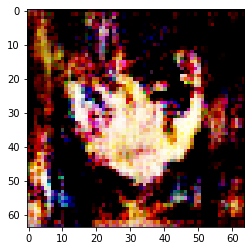

In [14]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Erhalten Sie zufällig Trainingsbilder
#dataiter = iter(arr_foutput)
#images, labels = dataiter.next()

# Bild anzeigen
#imshow(torchvision.utils.make_grid(arr_foutput))

fake_plot = generator(torch.rand(batchSize, 3, 1, 1, device=device))
print(fake_plot[0].shape)
#Einzelnes Bild ausgeben
img = fake_plot[9].detach().numpy()
nimg = np.transpose(img, (1, 2, 0))
print(nimg.shape)
plt.imshow(nimg)
plt.show()


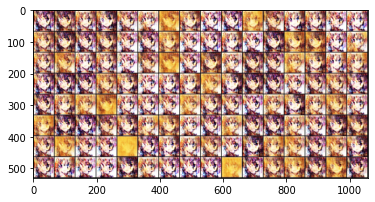

In [17]:
from torch.autograd import Variable
from torchvision.utils import make_grid

fake_grid = generator(torch.rand(batchSize, 3, 1, 1, device=device))
grid = make_grid(fake_grid, nrow=16,
                 normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.show()


In [12]:
##outputs.append((true_image,fake_generated)) 
###outputs[art][batch][image]

#outputs[0] -> Alle Batches (10) mit true_images
#outputs[0][i] -> i-ter Batch mit 10 true_images
#outputs[0][i][n] -> i-ter Batch mit dem n-ten true_images aus dem batch

#outputs[1] -> Alle Batches (10) mit true_images
#outputs[1][i] -> i-ter Batch mit 10 true_images
#outputs[1][i][n] -> i-ter Batch mit dem n-ten true_images aus dem batch
#Epochen = 5 - Batches = 520 - Batchgröße = 10
for epoch in range(5):
    for batch in range(1):
        #true_batch = outputs[0][batch]
        fake_batch = fake_outputs[batch]
        #true_grid_img = torchvision.utils.make_grid(true_batch, nrow=10).cpu()
        fake_grid_img = torchvision.utils.make_grid(fake_batch, nrow=5).cpu()
        #plt.imshow(true_grid_img.permute(1, 2, 0))
        plt.imshow(fake_grid_img.permute(1, 2, 0))

IndexError: list index out of range

In [ ]:
#print(foutput.shape)
#print(foutput.type)
tup_foutput = []
tup_foutput = torch.tensor_split(foutput, 10, dim=0)
arr_foutput = []
for x in tup_foutput:
    x = torch.squeeze(x)
    print(x.shape)
    arr_foutput.append(x)
print(type(arr_foutput))
print(len(arr_foutput))